In [1]:
import pandas as pd
import geopandas as gpd
from datetime import time, timedelta, datetime, date 
import contextily as cx
import numpy as np
import json
import numpy as np
from pathlib  import Path
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

In [2]:
#ho cambiato il percorso così da lavorare direttamente nella repo
data_path = Path('.././data/raw')
data_path2 = Path('.././data/external')
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',        
         'NOV-DATA':'SET-nov-2013.csv',
         'DEC-DATA':'SET-dec-2013.csv',
         'SET-lines':'line.csv',
         'inquinamento' :  'APPA_inquinamento_aria_Nov_Dec_2013.csv',
         'meteo': 'meteotrentino-weather-station-data.json'
        }

In [3]:
# guardiamo dati riguardo l'inquinamento orario  nei mesi di dicembre e novembre 2013 
df_inquinamento= pd.read_csv(data_path2 / files['inquinamento'] , encoding='latin-1')
#pd.unique(df_inquinamento.Inquinante)

### Importiamo dati grid e li aggiustiamo

In [72]:
with open(data_path / files['grid']) as f:
    grid_json = json.load(f)

#comandi utili per capire cosa c'è nel file .json
#print(grid_json.keys())
#print(grid_json['crs'])
#print(grid_json['type'])
#grid_json['features'][1]
grid = gpd.GeoDataFrame(grid_json['features'])

#converto la colonna geometry nel formato Polygon di shapely
grid['geometry'] = grid['geometry'].apply(lambda x:Polygon(x['coordinates'][0]))

#### Questa parte imposta il crs del geoDataFrame ######
# Import specific function 'from_epsg' from fiona module
from fiona.crs import from_epsg
# Set the GeoDataFrame's coordinate system to WGS84
grid.crs = from_epsg(code = 4326)

/home/gianmarco/anaconda3/envs/DS_2022/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


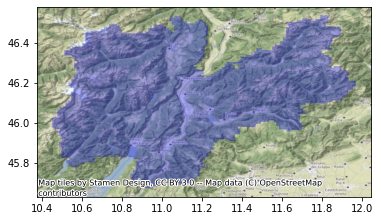

In [80]:
grid['id'] = grid['properties'].apply(lambda x: x['cellId'])
axgrid = grid.plot(color='blue', alpha=0.3) #vediamo che la mappa si plotta decentemente
#sovrappongo mappa del trentino
cx.add_basemap(axgrid, crs=grid.crs.to_string() ) 
#per salvare la figura :)
#plt.savefig("mappaTrentinoBlu.pdf", bbox_inches='tight' , dpi=300) 

### Importazione e sistemazione dati relativi ai consumi elettrici

In [8]:
#creo dataframe con dati relativi ai consumi di ogni linea ogni 10 min
nomi = ['LINESET', 'time', 'consumi']
df_consumi = pd.read_csv(data_path / files['NOV-DATA'], names = nomi)
df_linee = pd.read_csv(data_path / files['SET-lines'])

In [11]:
#groupby per contare le ubicazioni totali di ogni linea
dgrouped = df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()
df_ubi = pd.DataFrame(dgrouped)
df_ubi.reset_index()

In [81]:
#groupby per sommare i consumi del mese su ogni linea
dgroupedcon = df_consumi.groupby('LINESET')['consumi'].sum()
df_con = pd.DataFrame(dgroupedcon)
df_con = df_con.reset_index()

In [83]:
#uniamo i dataframes per calcolare il consumo per ubicazione di ogni linea
df_consumoperub = pd.merge(left = df_con, right = df_ubi, how = 'outer',on='LINESET')
df_consumoperub = df_consumoperub.fillna(0)
df_consumoperub['cons_per_ubi'] = df_consumoperub['consumi'] / df_consumoperub['NR_UBICAZIONI']

In [ ]:
#calcolo consumo mensile per ogni cella territoriale

#uniamo il dataframe appena ottenuto a quello delle linee e calcoliamo il consumo di ogni linea in ogni cella
df_cons_per_cella = pd.merge(left = df_linee, right = df_consumoperub[['LINESET','cons_per_ubi']], how = 'outer',on='LINESET')
df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
#groupby per sapere l'effettivo consumo per cella sommando sulle linee che ci passano attraverso 
dgrouped = df_cons_per_cella.groupby('SQUAREID')['consumo_per_cella'].sum()
df_cons_per_cella = pd.DataFrame(dgrouped)
df_cons_per_cella = df_cons_per_cella.reset_index()
#df_cons_per_cella

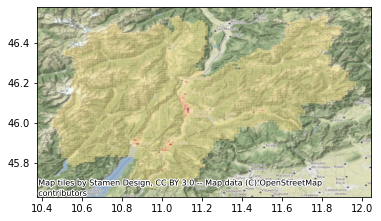

In [103]:
#merge con il geoDataFrame grid (che contiene la geometry)
df_mappa = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID'  )
df_mappa['consumo_per_cella'] = df_mappa['consumo_per_cella'].fillna(0)
ax_consumi_nov = df_mappa.plot('consumo_per_cella', cmap = 'YlOrRd', alpha=0.5)
cx.add_basemap(ax_consumi_nov, crs=grid.crs.to_string() ) 
#per salvare figura
#plt.savefig("mappaTrentinoConsumiNov.pdf", bbox_inches='tight' , dpi=500) 

In [88]:
#questa riga di codice serve per vedere se ci sono linee che passano in celle ma non hanno consumo, perchè evidentemente non hanno ubicazioni 
#spoiler nel dataset di novembre ce ne sono ben 37
#per ora abbandoniamo l'idea di un plot in scala logaritmica
#sum(df_mappa.consumo_per_cella == 0)

# tentativo di fare una scala logaritmica 
#df_mappa['log_consumi'] = np.log(df_mappa['consumo_per_cella'])
#mynorm = mpl.colors.LogNorm(vmin=np.nanmin(df_mappa.iloc[:,5].values) ,vmax=df_mappa['consumo_per_cella'].max() )
#df_mappa.plot('consumo_per_cella', cmap = 'YlOrRd', norm=mynorm)
#df_mappa['consumo_per_cella'].min()

### Indagine sulle variazioni di consumi tra giorno e notte

In [25]:
# abbiamo diviso la colonna time in data e ora per riuscire a gestire meglio i dati
#df_consumi[['Date', 'hour']] =df_consumi['time'].str.split(' ', expand=True)
# divido le celle 
df_consumi[['giorno','ora']] = df_consumi.time.str.split(" ",expand=True)
df_consumi.time = df_consumi.time.apply(datetime.fromisoformat)
# uso magia di stack exchange per dividere il database in due database uno con i consumi diurni e uno con i consumi notturni 
mask = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
          .between(pd.Timedelta('08:30:00'), pd.Timedelta('17:00:00')))
df_consumidiurni = df_consumi[mask]
df_consuminotturni = df_consumi[~mask]
#vogliamo arrivare alla loro differenza (normalizzata sul numero di ore!)

In [105]:
#poiché la procedura è identica a quella sopra per ricavare la mappa,
#meglio mettere tutto in una funzione 
def plotmap( datiConsumi, df_linee, grid ):
    ''' Plotta una mappa in scala di colore a partire dai dati relativi ai consumi (descrizione da completare)'''
    #contiamo le ubicazioni per linea
    df_ubi_per_line = pd.DataFrame(df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()).reset_index()
    #contiamo i consumi per linea
    df_con_per_line = pd.DataFrame( datiConsumi.groupby('LINESET')['consumi'].sum() ).reset_index()
    #uniamo i due dataframe
    df_consperub = pd.merge(left = df_con_per_line, right = df_ubi_per_line, how = 'outer',on='LINESET' )
    df_consperub = df_consperub.fillna(0)
    #calcolo dei consumi per ubicazione
    df_consperub['cons_per_ubi'] = df_consperub['consumi'] / df_consperub['NR_UBICAZIONI']
    #unisco al dataframe con le linee e le rispettive celle
    df_cons_per_cella = pd.merge(left = df_linee, right = df_consperub[['LINESET','cons_per_ubi']], how = 'outer',on='LINESET' )
    df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
    #sommo i consumi della stessa cella (diverse linee)
    dgrouped2 = df_cons_per_cella.groupby('SQUAREID')['consumo_per_cella'].sum()
    df_cons_per_cella = pd.DataFrame(dgrouped2)
    df_cons_per_cella = df_cons_per_cella.reset_index()
    #finalmente unisco tutto al dataframe della mappa che viene ritornato
    df_mappa = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID'  )
    df_mappa['consumo_per_cella'] = df_mappa_['consumo_per_cella'].fillna(0)
    return df_mappa
    

In [33]:

dgroupedcondiurni = df_consumidiurni.groupby('LINESET')['consumi'].sum()
df_condiurni = pd.DataFrame(dgroupedcondiurni)
#df_condiurni.head

In [34]:
df_condiurni = df_condiurni.reset_index()
df_consumoperubdiurni = pd.merge(left = df_condiurni, right = df_ubi, how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
df_consumoperubdiurni = df_consumoperubdiurni.fillna(0)
#df_consumoperubdiurni

In [35]:
df_consumoperubdiurni['cons_per_ubi'] = df_consumoperubdiurni['consumi'] / df_consumoperubdiurni['NR_UBICAZIONI']
df_cons_per_cella_diurni = pd.merge(left = df_linee, right = df_consumoperubdiurni[['LINESET','cons_per_ubi']], how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
df_cons_per_cella_diurni['consumo_per_cella'] = df_cons_per_cella_diurni['NR_UBICAZIONI']*df_cons_per_cella_diurni['cons_per_ubi']
dgroupeddiurni = df_cons_per_cella_diurni.groupby('SQUAREID')['consumo_per_cella'].sum()
df_cons_per_cella_diurni = pd.DataFrame(dgroupeddiurni)
df_cons_per_cella_diurni = df_cons_per_cella_diurni.reset_index()
#df_cons_per_cella_diurni

,SQUAREID,LINESET,NR_UBICAZIONI,cons_per_ubi,consumo_per_cella
0,155,DG1031221,4,50.943535,203.774140
1,272,DG1031221,72,50.943535,3667.934528
2,273,DG1031221,21,50.943535,1069.814237
3,389,DG1031221,65,50.943535,3311.329782
4,390,DG1031221,8,50.943535,407.548281
...,...,...,...,...,...
2570,10868,DG1013504,9,997.818469,8980.366222
2571,10982,DG1013504,1,997.818469,997.818469
2572,10983,DG1013504,5,997.818469,4989.092346
2573,10984,DG1013504,2,997.818469,1995.636938


<AxesSubplot:>

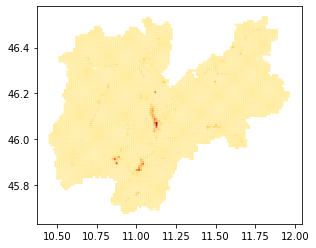

In [37]:
df_mappa_diurni = pd.merge(left = grid, right = df_cons_per_cella_diurni, how = 'left', left_on='id', right_on='SQUAREID'  )
df_mappa_diurni['consumo_per_cella'] = df_mappa_diurni['consumo_per_cella'].fillna(0)
df_mappa_diurni.plot('consumo_per_cella', cmap = 'YlOrRd' )
#df_mappa_diurni.head(40)

In [38]:
df_consumoperubdiurni

,LINESET,consumi,NR_UBICAZIONI,cons_per_ubi
0,DG1000420,96261.115736,2133,45.129449
1,DG1000421,31753.678718,1424,22.298932
2,DG1000422,36189.958368,3423,10.572585
3,DG1000423,28743.838723,656,43.816827
4,DG1000425,50326.137689,2013,25.000565
...,...,...,...,...
195,DG1099206,0.000000,105,0.000000
196,DG1099207,0.000000,95,0.000000
197,DG1099303,0.000000,39,0.000000
198,DG1099502,0.000000,3,0.000000


In [40]:
df_mappa_giorno = plotmap( df_consumidiurni, df_linee , grid)
df_mappa_notte = plotmap( df_consuminotturni, df_linee, grid)
#df_mappa_giorno.head(40) #3762.252046
#df_mappa_notte#df_mappa_generale.head(40) #3762.25204
df_mappa_generale = plotmap( df_consumi, df_linee, grid)

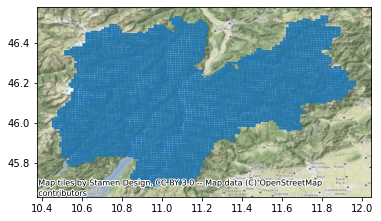

In [41]:
ax = df_mappa_generale.plot()
cx.add_basemap(ax, crs=df_mappa_generale.crs.to_string())

<AxesSubplot:>

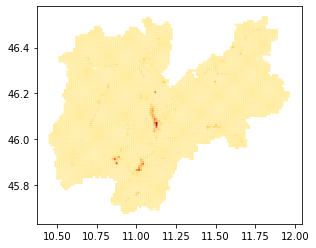

In [ ]:
df_mappa_giorno.plot('consumo_per_cella', cmap = 'YlOrRd' )

<AxesSubplot:>

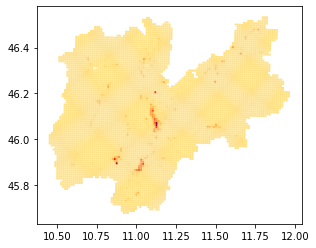

In [ ]:
df_mappa_notte.plot('consumo_per_cella', cmap = 'YlOrRd' )

In [ ]:
df_consumi

,LINESET,time,consumi,giorno,ora
0,DG1000420,2013-11-01 00:00:00,37.439999,2013-11-01,00:00
1,DG1000420,2013-11-01 00:10:00,37.439999,2013-11-01,00:10
2,DG1000420,2013-11-01 00:20:00,36.000000,2013-11-01,00:20
3,DG1000420,2013-11-01 00:30:00,35.279999,2013-11-01,00:30
4,DG1000420,2013-11-01 00:40:00,35.279999,2013-11-01,00:40
...,...,...,...,...,...
794513,DG1056626,2013-11-30 23:10:00,46.549999,2013-11-30,23:10
794514,DG1056626,2013-11-30 23:20:00,44.650002,2013-11-30,23:20
794515,DG1056626,2013-11-30 23:30:00,44.599998,2013-11-30,23:30
794516,DG1056626,2013-11-30 23:40:00,43.700001,2013-11-30,23:40


In [ ]:
# ho aggiunto una colonna che mi enumera i giorni della settimana 
df_consumi["giorno"] = pd.to_datetime(df_consumi["giorno"])
df_consumi["DayOfWeek"] = df_consumi["giorno"].dt.weekday
df_consumi

,LINESET,time,consumi,giorno,ora,DayOfWeek
0,DG1000420,2013-11-01 00:00:00,37.439999,2013-11-01,00:00,4
1,DG1000420,2013-11-01 00:10:00,37.439999,2013-11-01,00:10,4
2,DG1000420,2013-11-01 00:20:00,36.000000,2013-11-01,00:20,4
3,DG1000420,2013-11-01 00:30:00,35.279999,2013-11-01,00:30,4
4,DG1000420,2013-11-01 00:40:00,35.279999,2013-11-01,00:40,4
...,...,...,...,...,...,...
794513,DG1056626,2013-11-30 23:10:00,46.549999,2013-11-30,23:10,5
794514,DG1056626,2013-11-30 23:20:00,44.650002,2013-11-30,23:20,5
794515,DG1056626,2013-11-30 23:30:00,44.599998,2013-11-30,23:30,5
794516,DG1056626,2013-11-30 23:40:00,43.700001,2013-11-30,23:40,5


In [ ]:
# ho aggiunto un altra colonna che mi dice se il giorno è un week end o meno
df_consumi["isweekend"] = df_consumi["giorno"].dt.weekday > 4
Ntot = len(df_consumi.index)

In [ ]:
# adesso procedo a dividere in due il database in base alla condizione weekend o meno
# proverò a farlo con la stessa procesura seguita per il giorno e la notte 

In [ ]:
# sono riuscita a dividere i due database filtrando con la condizione sulla colonna DayOfweek molto più comoda di isweekend 

In [ ]:
df_consumisettimana = df_consumi[df_consumi.DayOfWeek < 5]
Nset = len(df_consumisettimana.index)


In [ ]:
df_consumiweekend = df_consumi[df_consumi.DayOfWeek > 4]

In [ ]:
df_mappa_settimana = plotmap( df_consumisettimana, df_linee , grid)
df_mappa_weekend = plotmap( df_consumiweekend, df_linee, grid)
#normalizzo
df_mappa_settimana['consumo_per_cella']/=Nset*144
df_mappa_weekend['consumo_per_cella']/=(Ntot-Nset)*144
# ci sono 144 righe ogni giorno 


In [ ]:
df_mappa_settimana

,geometry,type,id,properties,SQUAREID,consumo_per_cella
0,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",Feature,38,{'cellId': 38},NaN,0.000000
1,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",Feature,39,{'cellId': 39},NaN,0.000000
2,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",Feature,40,{'cellId': 40},NaN,0.000000
3,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",Feature,154,{'cellId': 154},NaN,0.000000
4,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",Feature,155,{'cellId': 155},155.0,0.000005
...,...,...,...,...,...,...
6570,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",Feature,11336,{'cellId': 11336},NaN,0.000000
6571,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",Feature,11337,{'cellId': 11337},NaN,0.000000
6572,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",Feature,11452,{'cellId': 11452},NaN,0.000000
6573,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",Feature,11453,{'cellId': 11453},NaN,0.000000


In [ ]:
#faccio la differenza tra i consumi della settimana e quelli del weekend.

df_mappa_weekend['DIFFCONSUMI'] = df_mappa_settimana['consumo_per_cella']-df_mappa_weekend['consumo_per_cella']


<AxesSubplot:>

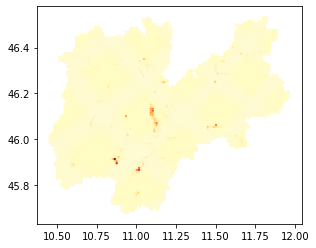

In [ ]:
df_mappa_weekend.plot('DIFFCONSUMI', cmap="YlOrRd")

In [ ]:
with open(data_path / files['adm_reg']) as f:
    adm_json = json.load(f)
print(adm_json.keys())

dict_keys(['count', 'items', 'datagem-version'])


In [ ]:
from shapely.geometry import Point

In [ ]:
gdf_adm = gpd.GeoDataFrame(adm_json['items'])
gdf_adm['geometry'][0]['coordinates'][0][0][0]
punto = Point(  gdf_adm['geometry'][0]['coordinates'][0][0][0],gdf_adm['geometry'][0]['coordinates'][0][0][1]     ) 
#gdf_adm['geometry'] = gdf_adm['geometry'].dropna()
#gdf_adm = gdf_adm['geometry'].apply(lambda x:Point(  x['coordinates'][0][0][0],x['coordinates'][0][0][1]     ) )
#gdf_adm.explore()
#print(punto)

In [ ]:
gdf_adm.columns

Index(['euroCode', 'website', 'population', 'cadastralCode', 'elevation',
       'acheneID', 'name', 'level', 'geometry', 'provenance', 'wikipedia',
       'isProvinceCheflieu', 'postCodes', 'parentAchenes', 'alternateNames',
       'localCode', 'isMountainMunicipality', 'geomComplex'],
      dtype='object')

In [ ]:
#gdf_comuni = gpd.GeoDataFrame( data=[gdf_adm['name'], gdf_adm['geometry']  ], index=gdf_adm.index ) 
gdf_comuni = gdf_adm[['name','geometry']]
gdf_comuni
dgrouped = gdf_comuni.groupby('name')['geometry'].sum()
gdf_com = pd.DataFrame(dgrouped)
gdf_com = gdf_com.reset_index()
gdf_com = gdf_com[gdf_com.geometry != 0]
print(gdf_com)

                name                                           geometry
3                Ala  {'type': 'Polygon', 'coordinates': [[[11.00168...
6            Albiano  {'type': 'Polygon', 'coordinates': [[[11.20856...
7             Aldeno  {'type': 'Polygon', 'coordinates': [[[11.10405...
10            Amblar  {'type': 'Polygon', 'coordinates': [[[11.16986...
11            Andalo  {'type': 'MultiPolygon', 'coordinates': [[[[11...
..               ...                                                ...
908    Villa Rendena  {'type': 'Polygon', 'coordinates': [[[10.60991...
919           Volano  {'type': 'Polygon', 'coordinates': [[[11.07405...
922          Zambana  {'type': 'MultiPolygon', 'coordinates': [[[[11...
927  Ziano di Fiemme  {'type': 'Polygon', 'coordinates': [[[11.55934...
935            Zuclo  {'type': 'MultiPolygon', 'coordinates': [[[[10...

[217 rows x 2 columns]


In [ ]:
gdf_com['geometry'][11]

{'type': 'MultiPolygon',
 'coordinates': [[[[11.002860122173386, 46.18067039235295],
    [11.003412492129556, 46.180491319042844],
    '...']],
  [[[10.934979499890332, 46.1588931962302],
    [10.93624100121862, 46.15862196452067],
    '...']]]}

In [ ]:
#df_adm['geometry'] = df_adm['geometry'].apply(lambda x:Polygon(x['coordinates']))
#df_adm.head(165)

In [ ]:
# uso magia di stack exchange per dividere il database in due database uno con i consumi diurni e uno con i consumi notturni 
maskday = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
          .between(pd.Timedelta('08:00:00'), pd.Timedelta('19:00:00')))
maskevening = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
          .between(pd.Timedelta('19:00:00'), pd.Timedelta('24:00:00')))

In [ ]:
df_consumiday = df_consumi[maskday]
df_consumievening = df_consumi[maskevening]
df_consumiday = df_consumiday[df_consumiday.DayOfWeek < 5]
df_consumiday
df_consumievening = df_consumievening[df_consumievening.DayOfWeek < 5]
df_consumievening

,LINESET,time,consumi,giorno,ora,DayOfWeek,isweekend
114,DG1000420,2013-11-01 19:00:00,51.839996,2013-11-01,19:00,4,False
115,DG1000420,2013-11-01 19:10:00,51.839996,2013-11-01,19:10,4,False
116,DG1000420,2013-11-01 19:20:00,50.759998,2013-11-01,19:20,4,False
117,DG1000420,2013-11-01 19:30:00,49.499996,2013-11-01,19:30,4,False
118,DG1000420,2013-11-01 19:40:00,50.039997,2013-11-01,19:40,4,False
...,...,...,...,...,...,...,...
794369,DG1056626,2013-11-29 23:10:00,47.450001,2013-11-29,23:10,4,False
794370,DG1056626,2013-11-29 23:20:00,45.875000,2013-11-29,23:20,4,False
794371,DG1056626,2013-11-29 23:30:00,44.799999,2013-11-29,23:30,4,False
794372,DG1056626,2013-11-29 23:40:00,44.299999,2013-11-29,23:40,4,False


In [ ]:
# possiamo dividere i dati fra train e test 

In [ ]:
def calcolaconsumi( datiConsumi, df_linee, grid ):
    ''' Plotta una mappa in scala di colore a partire dai dati relativi ai consumi (descrizione da completare)'''
    dgrouped1 = df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()
    df_ubi = pd.DataFrame(dgrouped1)
    ##print(df_ubi)
    dgrouped = datiConsumi.groupby(['LINESET', 'giorno'])['consumi'].sum()
    df_con1 = pd.DataFrame(dgrouped)
    df_con1 = df_con1.reset_index()
    ##print(df_con1)
    #df_con1['giorno'] = df_con1['giorno'].apply(date.fromisoformat)
    df_consperub = pd.merge(left = df_con1, right = df_ubi, how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
    #print(df_consperub.isna().sum()) avevo provato a contare i nan 
    # non curiamo i nan perchè causano problemi nel groupby
    df_consperub['cons_per_ubi'] = df_consperub['consumi'] / df_consperub['NR_UBICAZIONI']
    ##print(df_consperub)
    df_cons_per_cella = pd.merge(left = df_linee, right = df_consperub[['LINESET','giorno','cons_per_ubi']], how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
    df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
    ##print(df_cons_per_cella.dtypes)
    #df_cons_per_cella[['solo_giorno','ora']] = df_cons_per_cella.giorno.str.split(" ",expand=True)
    #df_cons_per_cella['giorno'] = df_cons_per_cella['giorno'].apply(str())
    ##print(df_cons_per_cella)
    dgrouped2 = df_cons_per_cella.groupby(['SQUAREID', 'giorno'])['consumo_per_cella'].sum()
    df_cons_per_cella = pd.DataFrame(dgrouped2)
    df_cons_per_cella = df_cons_per_cella.reset_index()
    ##print(df_cons_per_cella)
    #df_mappa_ = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID'  )
    #df_mappa_['consumo_per_cella'] = df_mappa_['consumo_per_cella'].fillna(0)
    return df_cons_per_cella
    

In [ ]:
df_datidaclassificaregiorno = calcolaconsumi(df_consumiday , df_linee, grid )
df_datidaclassificaregiorno
df_datidaclassificaresera = calcolaconsumi(df_consumievening, df_linee, grid )
df_datidaclassificaresera

,SQUAREID,giorno,consumo_per_cella
0,155,2013-11-01,3.872696
1,155,2013-11-04,4.251826
2,155,2013-11-05,3.724522
3,155,2013-11-06,4.018783
4,155,2013-11-07,3.776348
...,...,...,...
41659,11099,2013-11-25,8.918567
41660,11099,2013-11-26,8.846445
41661,11099,2013-11-27,9.518397
41662,11099,2013-11-28,9.733409
